In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib as plt
import seaborn as sns
import tsfresh
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
ballotsdf = pd.read_csv('ballots_party_2019.csv')
partiesdf =  pd.read_csv('parties_Bremen_2019.csv').append({'party_id': 1500, 'shortname': 'The X-party', 'name': 'Some party that failed even to get listed properly'},ignore_index=True)
display(partiesdf)
display(ballotsdf)

,party_id,shortname,name
0,100,SPD,Sozialdemokratische Partei Deutschlands
1,200,CDU,Christlich Demokratische Union Deutschlands
2,300,GRÜNE,BÜNDNIS 90/DIE GRÜNEN
3,400,DIE LINKE,DIE LINKE
4,500,FDP,Freie Demokratische Partei
5,600,AfD,Alternative für Deutschland
6,700,PIRATEN,Piratenpartei Deutschland
7,800,Die PARTEI,"Partei für Arbeit, Rechtsstaat, Tierschutz, El..."
8,900,FREIE WÄHLER,FREIE WÄHLER
9,1000,BIW,BÜRGER IN WUT


,vote_1,vote_2,vote_3,vote_4,vote_5,n
0,100.0,100.0,100.0,100.0,100.0,47434
1,100.0,100.0,100.0,100.0,200.0,103
2,100.0,100.0,100.0,100.0,300.0,342
3,100.0,100.0,100.0,100.0,400.0,174
4,100.0,100.0,100.0,100.0,500.0,38
...,...,...,...,...,...,...
1274,1500.0,1500.0,1500.0,200.0,200.0,5
1275,1500.0,1500.0,1500.0,300.0,300.0,9
1276,1500.0,1500.0,1500.0,400.0,400.0,5
1277,1500.0,1500.0,1500.0,1500.0,1500.0,441


In [3]:
#replacing NaN with 0 - it seems to be quite natural
for column in ballotsdf:
    ballotsdf[column]=ballotsdf[column].apply(lambda x: 0 if np.isnan(x)==True else x)

In [4]:
#now we have to merge the same ballots where the order is the only different thing
def unique_ballots(df):
    combdf = pd.DataFrame({'Counter':[], 'Quantity':[]})
    for i in range(len(df)):
        counter = Counter(df.iloc[i, :5])
        if len(combdf[combdf.Counter == counter])==0:
            combdf = combdf.append({'Counter':counter, 'Quantity':df.iloc[i, 5]}, ignore_index=True)
        else:
            combdf.loc[combdf[combdf.Counter==counter].index, 'Quantity']+=df.iloc[i, 5]
    combdf.Counter = combdf.Counter.apply(lambda x: sum([[value]*key for value, key in zip(x.keys(), x.values())], []))
    vote_1 = combdf.Counter.apply(lambda x: x[0])
    vote_2 = combdf.Counter.apply(lambda x: x[1])
    vote_3 = combdf.Counter.apply(lambda x: x[2])
    vote_4 = combdf.Counter.apply(lambda x: x[3])
    vote_5 = combdf.Counter.apply(lambda x: x[4])
    newdf=pd.DataFrame({'vote_1': vote_1, 'vote_2': vote_2, 'vote_3': vote_3, 'vote_4': vote_4, 'vote_5':vote_5, 'quantity': combdf.Quantity})
    return newdf

unique_ballots_df = unique_ballots(ballotsdf).reset_index(drop=True)

In [5]:
#now we need to introduce some additional labelling of the data
def general_labelling(ballot):
    '''Maps the ballot to the parties or states the ballot is empty indicating all the percentages'''
    ranking = np.array(Counter(ballot).most_common())
    vote_list = []
    for party_votes in ranking:
        try:
            vote = (int(party_votes[1]*20), partiesdf[partiesdf.party_id==party_votes[0]].iloc[:, 1].reset_index(drop=True)[0])
            vote_list.append(vote)
        except KeyError:
            vote = (int(party_votes[1]*20), 'empty')
            vote_list.append(vote)      
    label = ';'.join([f'{vote[0]} percent for {vote[1]}' for vote in vote_list])
    return label
unique_ballots_df['general_label'] = unique_ballots_df.iloc[:, :5].apply(general_labelling, axis=1)

In [6]:
#and a label concerning emptiness
def empty_labelling(description):
    '''Auxiliary label indicating emptiness percentage'''
    if 'empty' in description:
        split = description.split(';')
        if len(split)>1:
            label = int(list(filter(lambda string: 'empty' in string, split))[0][:2])
        else:
            label=100
    else:
        label = 0
    return label    
unique_ballots_df['emptiness_percentage'] = unique_ballots_df['general_label'].apply(empty_labelling)

In [7]:
#and a label concerning the dominant party
def dominant_party(description):
    '''Auxiliary label giving the name of the dominant party'''
    split = description.split(';')
    if len(split)==1:
        if 'empty' in description:
            label = 'no dominant party'
        else:   
            label = split[0].split('for ')[1]
    else:
        if split[0][:2]==split[1][:2]:
            label = 'no dominant party'
        else:
            label = split[0].split('for ')[1]
    return label
unique_ballots_df['dominant_party'] = unique_ballots_df['general_label'].apply(dominant_party)

In [8]:
#and a label concerning parties involved
def parties_involved(description):
    '''Auxiliary label giving name of the parties voted for in the ballot'''
    split = description.split(';')
    if 'empty' in description and len(split)==1:
        label = 'no party'
    else:
        parties_percentages = list(filter(lambda string: 'empty' not in string, split))
        party_list = [parties_percentage.split('for ')[1] for parties_percentage in parties_percentages]
        party_list = sorted(party_list, reverse=True)
        label = ';'.join(party_list)
    return label
unique_ballots_df['parties_involved'] = unique_ballots_df['general_label'].apply(parties_involved)

In [263]:
#and the labels for political spectrum
left = ['DIE LINKE', 'GRÜNE', 'PIRATEN', 'Die PARTEI', 'BGE', 'V-Partei³', 'Die Humanisten']
right = ['AfD', 'BIW']
center= ['CDU', 'FDP', 'FREIE WÄHLER', 'MENSCHLICHE WELT', 'SPD']

def spectrum(ballot):
    '''Auxiliary label standing for the ballot's location on a priori political spectrum'''
    
    def attribution(party_name):
        '''Auxiliary function to identify the party postion on the spectrum given its name'''
        if party_name in left:
            position = 'left'
        elif party_name in right:
            position = 'right'
        elif party_name in center:
            position = 'center'
        elif party_name == 'The X-party':
            position='TBD'
        elif party_name == 'empty':
            position= 'null'
        return position

    ranking = np.array(Counter(ballot).most_common())
    vote_list = []
    for party_votes in ranking:
        try:
            vote = (int(party_votes[1]*20), partiesdf[partiesdf.party_id==party_votes[0]].iloc[:, 1].reset_index(drop=True)[0])
            vote_list.append(vote)
        except KeyError:
            vote = (int(party_votes[1]*20), 'empty')
            vote_list.append(vote)
    orientations =  list(map(attribution, [vote[1] for vote in vote_list]))
    positions = [(orientation, vote[0]) for orientation, vote in zip(orientations, vote_list)]
    results = [(sum([tuple[1] for tuple in list(filter(lambda position: position[0]==orientation, positions))]), orientation) for orientation in list(Counter(orientations))]
    results = sorted(results, reverse=True)
    if len(results)%2==0:
            label =  results[0][1]
    else:
        if len(results)==1:
            label=f'{results[0][1]}'
        elif len(results)==3:
                label= '+'.join(sorted([results[0][1], results[1][1]]))
        elif len(results)==5:
                label= 'indefinite'
    return label

unique_ballots_df['spectrum'] = unique_ballots_df.iloc[:, :5].apply(spectrum, axis=1)

In [264]:
#here we make dummy variables for each party
strdf = pd.DataFrame()
for col in unique_ballots_df:
    strdf[col] = unique_ballots_df[col].apply(str)
#drop_first=True?
strdf = pd.get_dummies(strdf, columns = ['vote_1', 'vote_2', 'vote_3', 'vote_4', 'vote_5'])

In [11]:
#we now got some label columns, so the function is needed to add them to the transformed ballots 
def new_dim_to_df(transformed):
    '''Receives a transformed values of ballots and returns a dataframe adding their quantity and labels from the initial df'''
    df = pd.DataFrame()
    for i in range(len(transformed[0])):
        df[f'Component_{i+1}'] = transformed[:, i]
    df = pd.concat([df, strdf.iloc[:, :6]], axis=1)
    return df

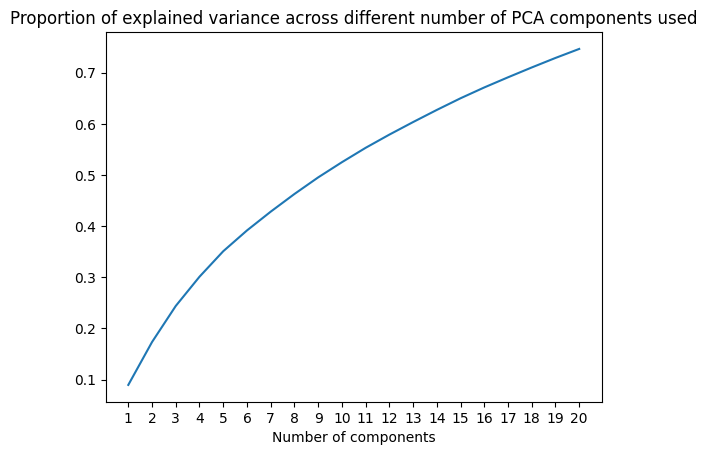

In [44]:
#the first dimensionality reduction technique we use is PCA
from sklearn.decomposition import PCA
var_explained = []
for i in range(1, 21):
    pca = PCA(n_components=i).fit(strdf.iloc[:, 6:])
    var_explained.append(sum(pca.explained_variance_ratio_))
plt.plot(var_explained)
plt.xticks(ticks=list(range(0, 20)), labels=list(range(1, 21)))
plt.xlabel('Number of components')
plt.title('Proportion of explained variance across different number of PCA components used')
plt.show()

In [265]:
#let us pick 10 components: the ratio seems to go down after this mark, and at the same time it explains over 50% of variance
pca = PCA(n_components=10, random_state=1).fit(X=strdf.iloc[:, 6:])
PCA_df = new_dim_to_df(transformed = pca.transform(X=strdf.iloc[:, 6:]))
PCA_df  

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,quantity,general_label,emptiness_percentage,dominant_party,parties_involved,spectrum
0,1.079895,-0.459744,-0.727041,0.222815,-0.193694,0.014932,-0.089395,0.408811,-0.167568,-0.180672,47434.0,100 percent for SPD,0,SPD,SPD,center
1,1.096543,-0.485862,-0.696466,0.235201,-0.207493,0.050242,-0.047873,0.383657,-0.138217,-0.131121,518.0,80 percent for SPD;20 percent for CDU,0,SPD,SPD;CDU,center
2,1.119467,-0.509582,-0.683799,0.210750,-0.178350,0.017706,-0.060588,0.324558,-0.170504,-0.131065,1087.0,80 percent for SPD;20 percent for GRÜNE,0,SPD,SPD;GRÜNE,center
3,1.131080,-0.543022,-0.675180,0.136121,-0.097706,0.014562,-0.097260,0.367460,-0.082467,-0.080788,583.0,80 percent for SPD;20 percent for DIE LINKE,0,SPD,SPD;DIE LINKE,center
4,1.140613,-0.533053,-0.635374,0.071227,-0.139251,0.372994,0.093525,0.277954,-0.334438,-0.053843,152.0,80 percent for SPD;20 percent for FDP,0,SPD,SPD;FDP,center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,-0.210140,0.248638,-0.132167,0.107509,-0.262445,-0.050606,-0.301892,0.134852,-0.283809,-0.435203,10.0,60 percent for Die Humanisten;40 percent for T...,0,Die Humanisten,The X-party;Die Humanisten,left
648,-0.209904,0.252568,-0.131713,0.101082,-0.243458,-0.063160,-0.291592,0.108007,-0.240819,-0.373620,8.0,60 percent for The X-party;40 percent for Die ...,0,The X-party,The X-party;Die Humanisten,TBD
649,0.222536,0.520683,0.071065,-0.066857,-0.105994,-0.271495,-0.080170,0.794326,-0.133884,-0.378359,5.0,60 percent for CDU;40 percent for The X-party,0,CDU,The X-party;CDU,center
650,-0.201900,0.245342,-0.125379,0.095030,-0.220685,-0.078404,-0.269998,0.108170,-0.193594,-0.316166,441.0,100 percent for The X-party,0,The X-party,The X-party,TBD


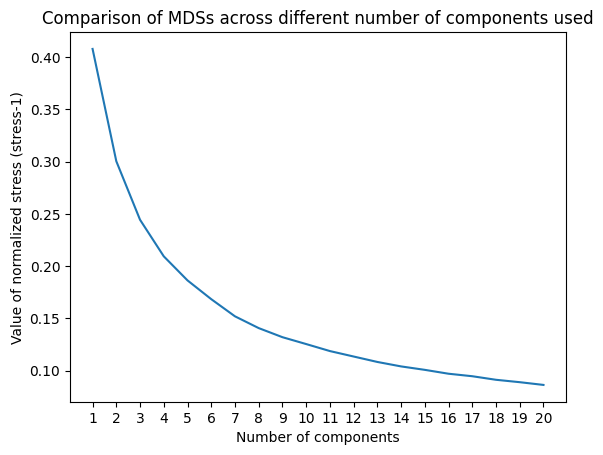

In [174]:
#another technique to be used is MDS
#we use normalized stress to be able to measure the fit quality despite it requires non-metric dissimilarity leading to information loss
from sklearn.manifold import MDS
stress = []
for i in range(1, 21):
    embedding = MDS(n_components=i, random_state=1, metric=False, normalized_stress=True)
    embedding.fit(strdf.iloc[:, 6:])
    stress.append(embedding.stress_)
plt.plot(stress)
plt.xticks(ticks=list(range(0, 20)), labels=list(range(1,21)))
plt.ylabel('Value of normalized stress (stress-1)')
plt.xlabel('Number of components')
plt.title('Comparison of MDSs across different number of components used')
plt.show()

In [266]:
#let us pick 5 components since there is not much of improvement after this mark and the stress below 0.2 is considered normal
embedding = MDS(n_components=5, random_state=1, metric=False, normalized_stress=True)
MDS_df = new_dim_to_df(transformed = embedding.fit_transform(strdf.iloc[:, 6:]))
MDS_df

,Component_1,Component_2,Component_3,Component_4,Component_5,quantity,general_label,emptiness_percentage,dominant_party,parties_involved,spectrum
0,0.241584,0.274223,0.148164,0.254461,-0.141786,47434.0,100 percent for SPD,0,SPD,SPD,center
1,0.206513,0.282191,-0.305406,-0.009611,-0.178684,518.0,80 percent for SPD;20 percent for CDU,0,SPD,SPD;CDU,center
2,0.016079,0.105129,-0.223267,0.319153,-0.198493,1087.0,80 percent for SPD;20 percent for GRÜNE,0,SPD,SPD;GRÜNE,center
3,0.147559,0.224181,0.285377,0.308617,0.104981,583.0,80 percent for SPD;20 percent for DIE LINKE,0,SPD,SPD;DIE LINKE,center
4,0.128609,0.079011,-0.002517,-0.087101,-0.402778,152.0,80 percent for SPD;20 percent for FDP,0,SPD,SPD;FDP,center
...,...,...,...,...,...,...,...,...,...,...,...
647,-0.093250,0.140419,-0.241952,0.324563,0.263047,10.0,60 percent for Die Humanisten;40 percent for T...,0,Die Humanisten,The X-party;Die Humanisten,left
648,-0.191451,0.072590,0.205992,0.335026,-0.030068,8.0,60 percent for The X-party;40 percent for Die ...,0,The X-party,The X-party;Die Humanisten,TBD
649,-0.284754,-0.322670,0.037852,-0.348835,0.095915,5.0,60 percent for CDU;40 percent for The X-party,0,CDU,The X-party;CDU,center
650,-0.367793,-0.394964,-0.335034,-0.087196,-0.100317,441.0,100 percent for The X-party,0,The X-party,The X-party,TBD


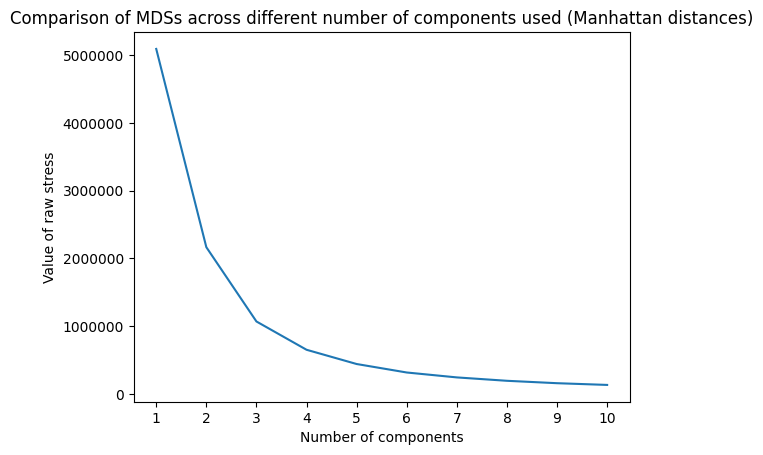

In [175]:
#for the MDS we can also use different dissimilarity (distance or pseudo-distance) matrix. Let us see what we get so
#here we use non-normalized noise, because otherwise exact distances will be disregarded
#for computational purposes we will loop over n_components in range(1, 11) only
from sklearn.metrics.pairwise import manhattan_distances
manhattan_distance = manhattan_distances(np.array(strdf.iloc[:, 6:]))
stress_manh = []
for i in range(1, 11):
    embedding_manh = MDS(n_components=i, random_state=1, dissimilarity='precomputed')
    embedding_manh.fit(manhattan_distance)
    stress_manh.append(embedding_manh.stress_)
plt.plot(stress_manh)
plt.yticks(ticks=list(range(0, 6000000, 1000000)), labels=list(range(0, 6000000, 1000000)))
plt.xticks(ticks=list(range(0, 10)), labels=list(range(1, 11)))
plt.ylabel('Value of raw stress')
plt.xlabel('Number of components')
plt.title('Comparison of MDSs across different number of components used (Manhattan distances)')
plt.show()

In [267]:
#let us pick 4
embedding_manh = MDS(n_components=4, random_state=1, dissimilarity='precomputed')
MDS_df_manh = new_dim_to_df(transformed = embedding_manh.fit_transform(manhattan_distance))
MDS_df_manh

,Component_1,Component_2,Component_3,Component_4,quantity,general_label,emptiness_percentage,dominant_party,parties_involved,spectrum
0,-0.761358,1.512577,-6.036096,-0.926979,47434.0,100 percent for SPD,0,SPD,SPD,center
1,-0.369610,1.564330,-6.111398,-1.030065,518.0,80 percent for SPD;20 percent for CDU,0,SPD,SPD;CDU,center
2,-0.176935,1.701033,-6.115505,-0.933724,1087.0,80 percent for SPD;20 percent for GRÜNE,0,SPD,SPD;GRÜNE,center
3,0.118986,1.700400,-6.064609,-0.748108,583.0,80 percent for SPD;20 percent for DIE LINKE,0,SPD,SPD;DIE LINKE,center
4,0.358290,2.280102,-5.594891,-1.360204,152.0,80 percent for SPD;20 percent for FDP,0,SPD,SPD;FDP,center
...,...,...,...,...,...,...,...,...,...,...
647,-0.286728,-5.301231,4.855565,1.447421,10.0,60 percent for Die Humanisten;40 percent for T...,0,Die Humanisten,The X-party;Die Humanisten,left
648,-0.843372,-5.418090,4.661752,1.435615,8.0,60 percent for The X-party;40 percent for Die ...,0,The X-party,The X-party;Die Humanisten,TBD
649,-0.076944,-5.519533,-3.379927,-2.965452,5.0,60 percent for CDU;40 percent for The X-party,0,CDU,The X-party;CDU,center
650,-3.705238,-5.355566,-2.141245,2.433980,441.0,100 percent for The X-party,0,The X-party,The X-party,TBD


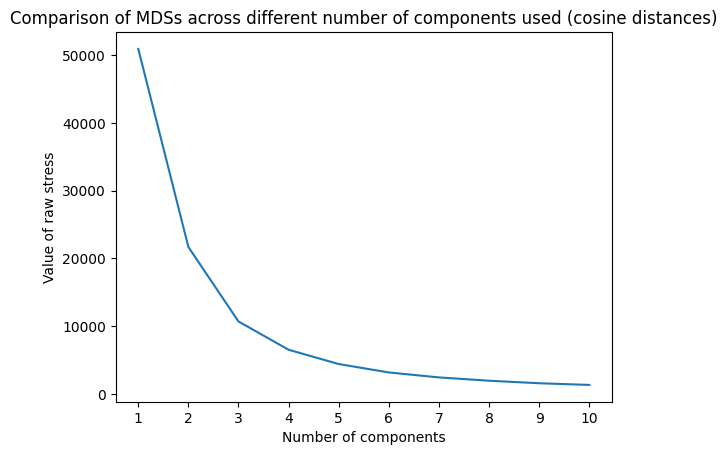

In [176]:
#let us try another distance - cosine one. As long as lengths of our vectors do not differ a lot, it might make sence
from sklearn.metrics.pairwise import cosine_distances
cosine_distance = cosine_distances(np.array(strdf.iloc[:, 6:]))
stress_cosine = []
for i in range(1, 11):
    embedding_cosine = MDS(n_components=i, random_state=1, dissimilarity='precomputed')
    embedding_cosine.fit(cosine_distance)
    stress_cosine.append(embedding_cosine.stress_)
plt.plot(stress_cosine)
plt.xticks(ticks=list(range(0, 10)), labels=list(range(1, 11)))
plt.ylabel('Value of raw stress')
plt.xlabel('Number of components')
plt.title('Comparison of MDSs across different number of components used (cosine distances)')
plt.show()

In [268]:
#4 seems to be a good option again
embedding_cosine = MDS(n_components=4, random_state=1, dissimilarity='precomputed')
MDS_df_cosine = new_dim_to_df(transformed = embedding_cosine.fit_transform(cosine_distance))
MDS_df_cosine

,Component_1,Component_2,Component_3,Component_4,quantity,general_label,emptiness_percentage,dominant_party,parties_involved,spectrum
0,-0.075595,0.154358,-0.602490,-0.095227,47434.0,100 percent for SPD,0,SPD,SPD,center
1,-0.036209,0.160126,-0.609753,-0.105900,518.0,80 percent for SPD;20 percent for CDU,0,SPD,SPD;CDU,center
2,-0.016749,0.173675,-0.610191,-0.096102,1087.0,80 percent for SPD;20 percent for GRÜNE,0,SPD,SPD;GRÜNE,center
3,0.012685,0.171637,-0.605857,-0.076035,583.0,80 percent for SPD;20 percent for DIE LINKE,0,SPD,SPD;DIE LINKE,center
4,0.036772,0.231016,-0.557769,-0.137910,152.0,80 percent for SPD;20 percent for FDP,0,SPD,SPD;FDP,center
...,...,...,...,...,...,...,...,...,...,...
647,-0.041514,-0.525335,0.488866,0.146570,10.0,60 percent for Die Humanisten;40 percent for T...,0,Die Humanisten,The X-party;Die Humanisten,left
648,-0.089926,-0.540883,0.465211,0.145749,8.0,60 percent for The X-party;40 percent for Die ...,0,The X-party,The X-party;Die Humanisten,TBD
649,-0.012535,-0.549618,-0.340205,-0.298246,5.0,60 percent for CDU;40 percent for The X-party,0,CDU,The X-party;CDU,center
650,-0.383333,-0.518626,-0.223643,0.252182,441.0,100 percent for The X-party,0,The X-party,The X-party,TBD


In [269]:
#now we need a function to extend the resulting df so that each ballot has its own row
def single_ballots(df, ncomponents):
    '''Returns a df where 1 row = 1 ballot given a df where 1 row = ballot's type+quantity of ballots of this type'''
    def duplicating(row):
        votes = row[:ncomponents]
        repeats = int(float(row[ncomponents]))
        labels = row[ncomponents+1:]
        to_repeat = [np.concatenate((votes, labels))]
        duplicated_row = pd.DataFrame(np.repeat(to_repeat,repeats, axis=0))
        duplicated_row
        return duplicated_row
    converted_df = pd.concat(list(df.apply(duplicating, axis=1))).reset_index(drop=True)
    columns_mapper = {converted_df_column:df_column for converted_df_column, df_column in zip(converted_df.columns, df.drop(columns='quantity').columns)}
    converted_df = converted_df.rename(columns=columns_mapper)
    return converted_df

#let us now apply it to the PCA df
PCA_df_long= single_ballots(PCA_df, ncomponents=10)

#and the same for MDS: simple, manhattan and cosine
MDS_df_long= single_ballots(MDS_df, ncomponents=5)
MDS_df_long_manh= single_ballots(MDS_df_manh, ncomponents=4)
MDS_df_long_cosine= single_ballots(MDS_df_cosine, ncomponents=4)

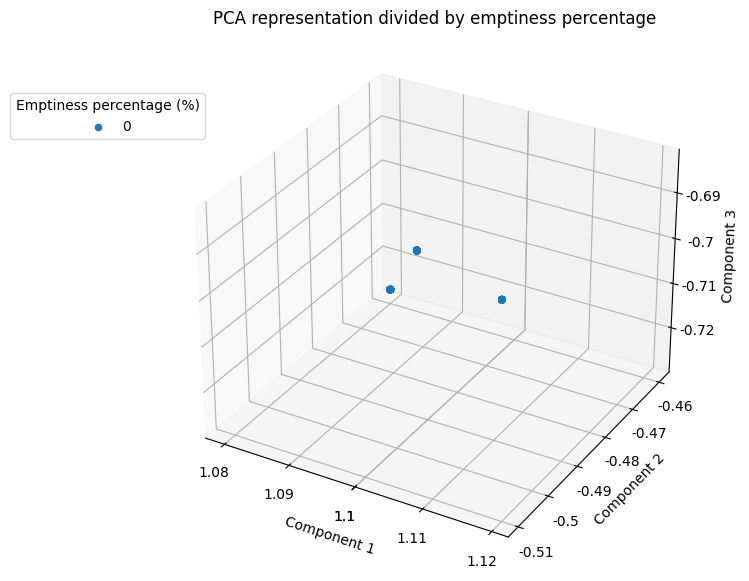

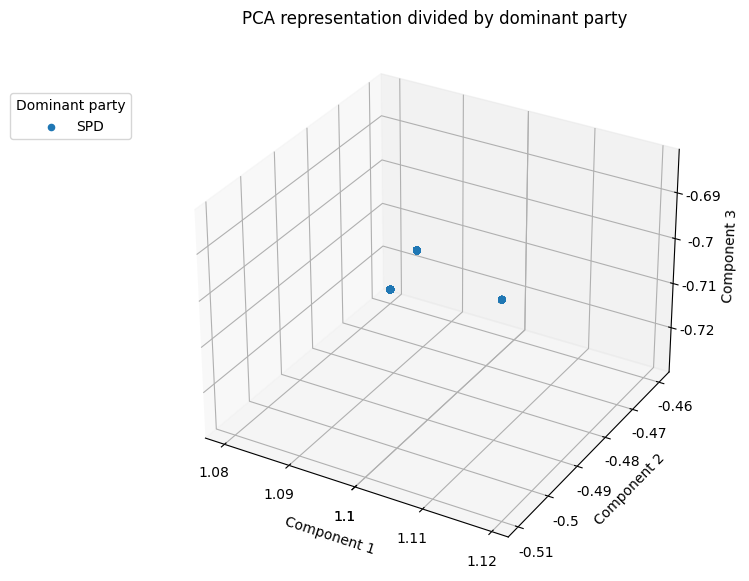

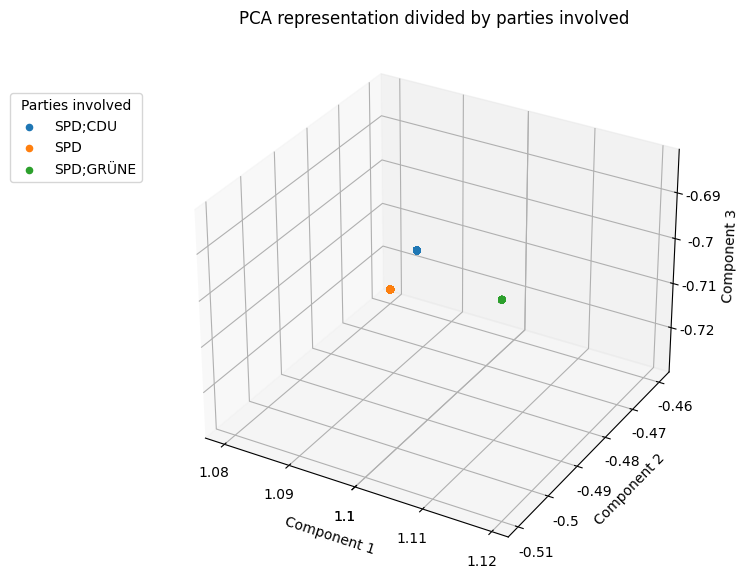

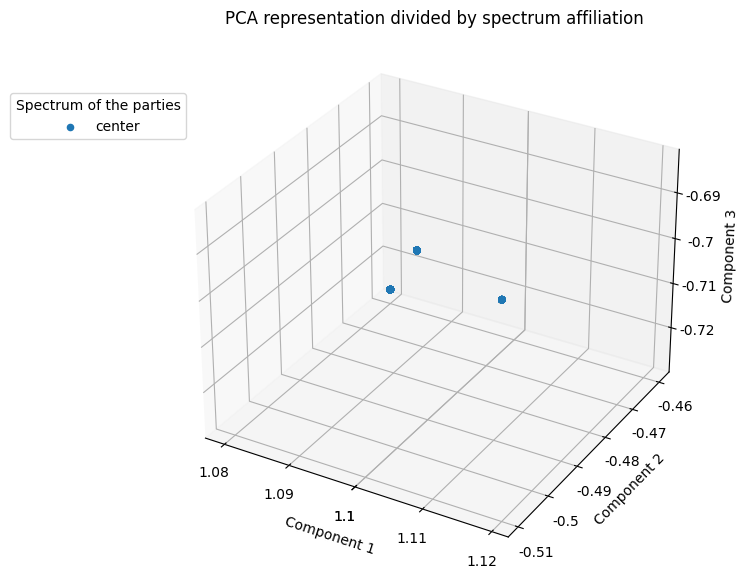

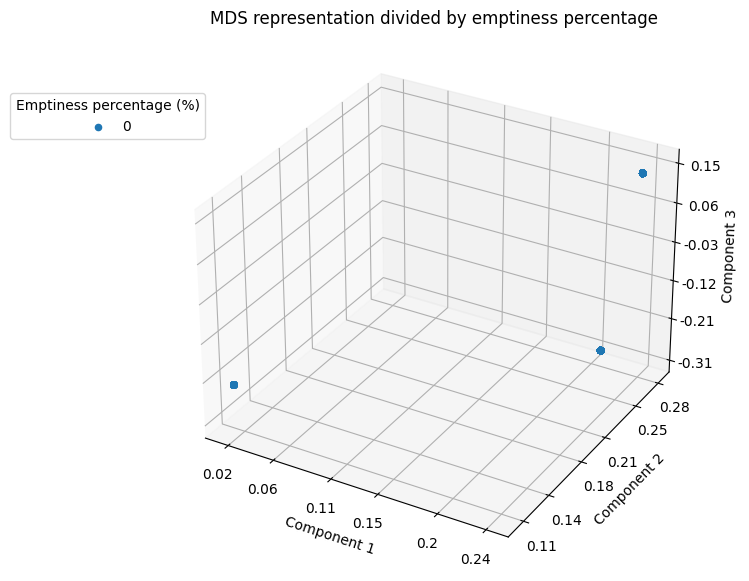

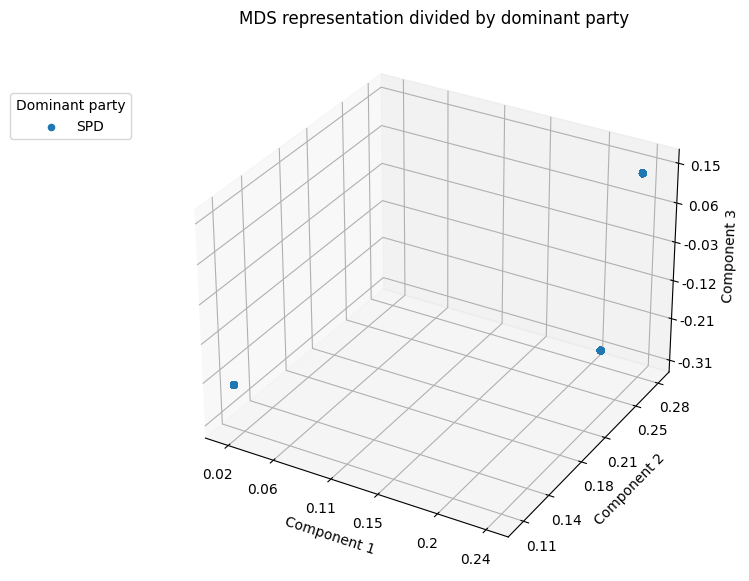

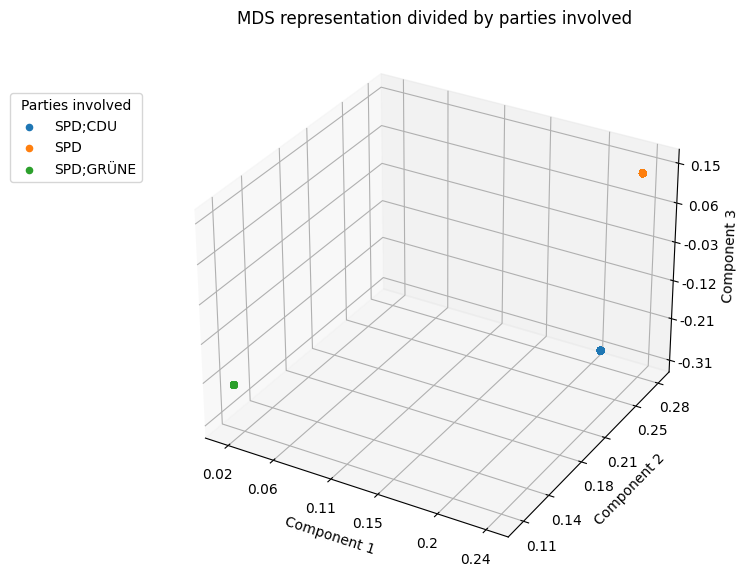

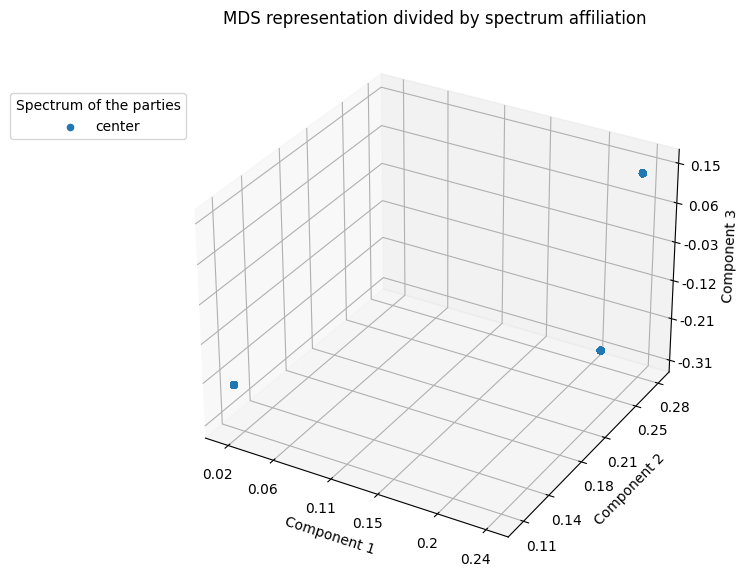

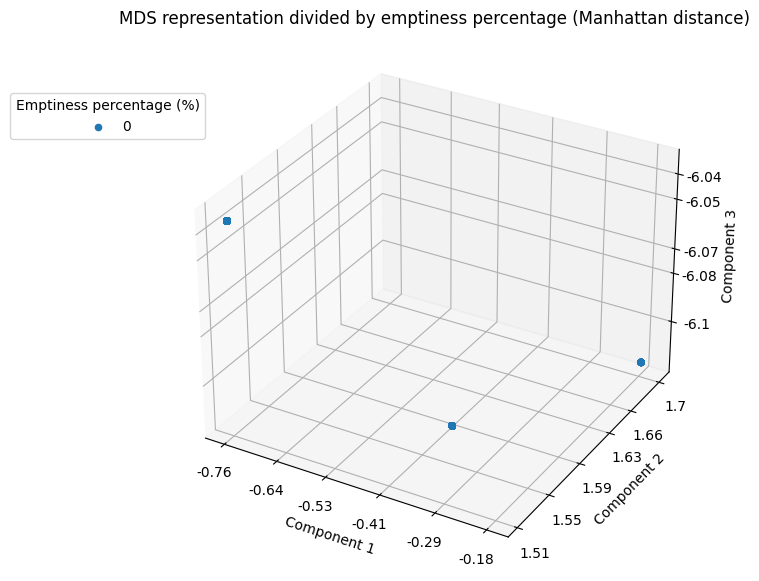

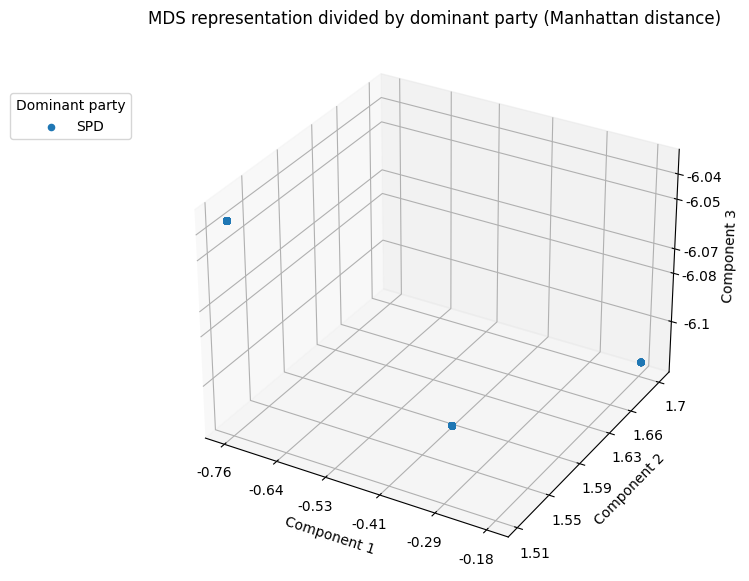

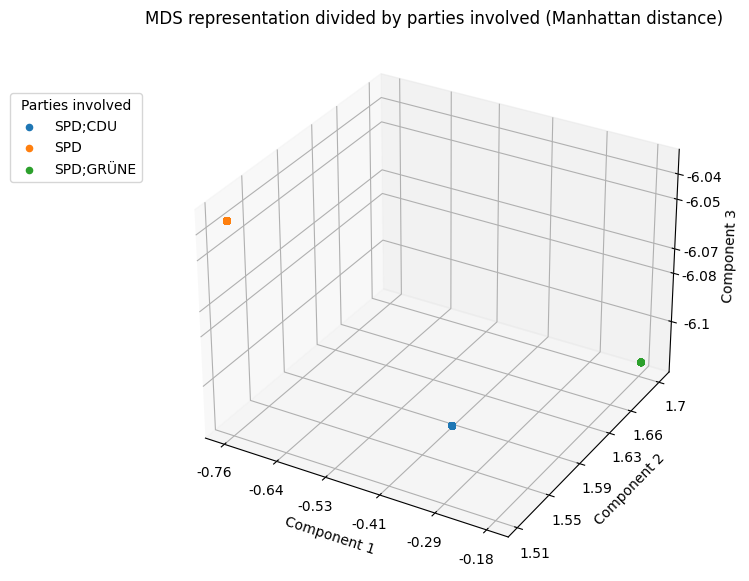

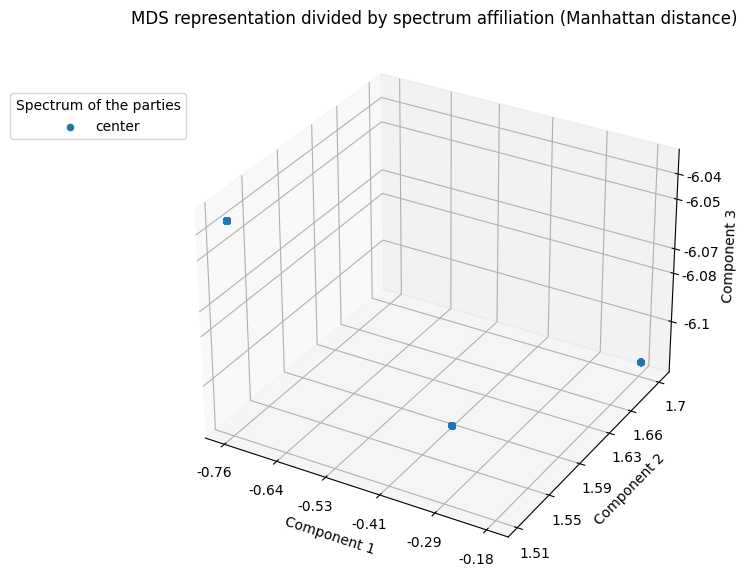

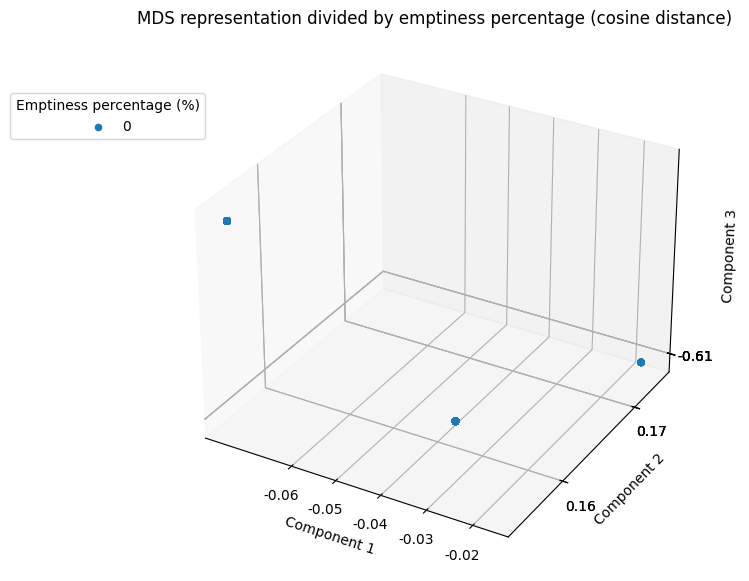

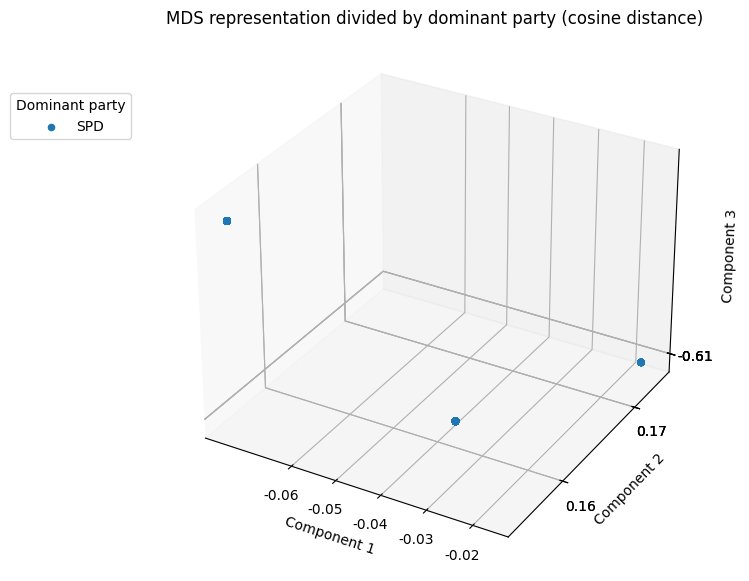

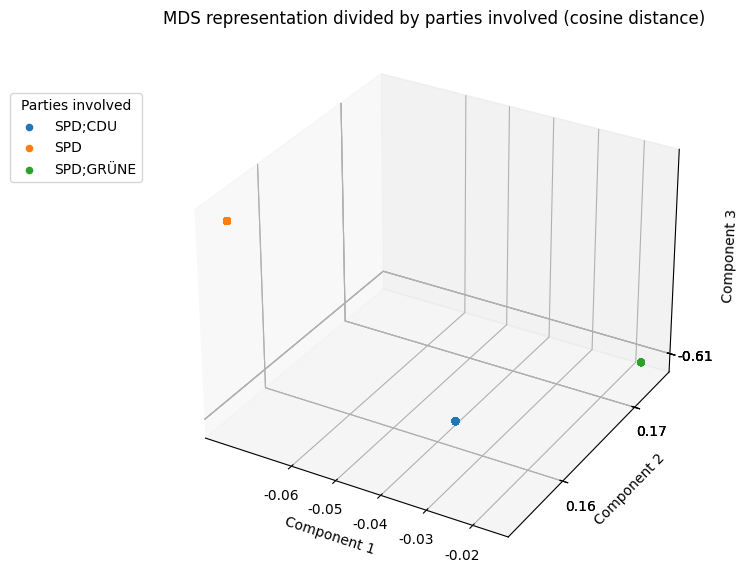

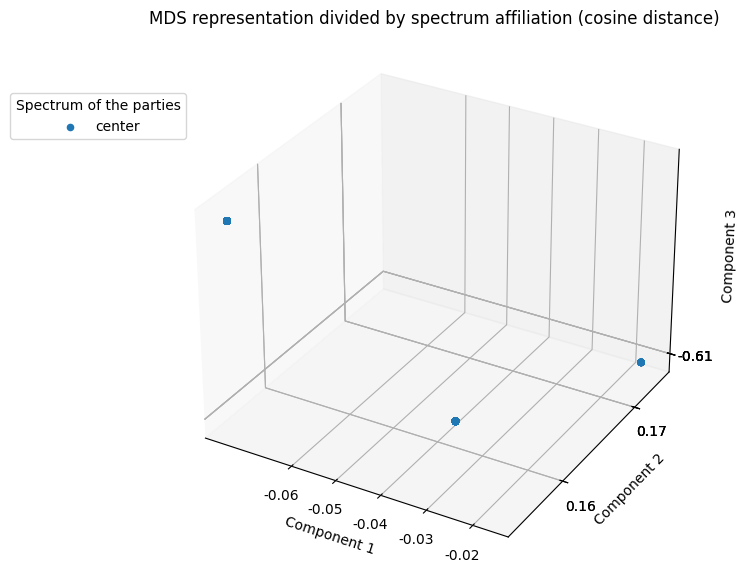

In [325]:
from mpl_toolkits import mplot3d
def plot(df, kind, type):
    '''Plots the data points in 3D and annotates the plot properly'''
    for col in df.loc[:, 'emptiness_percentage':]:
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")

        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        
        xticks = list(map(lambda x: round(x, ndigits=2), list(np.arange(min(df.Component_1), max(df.Component_1)+0.01, (max(df.Component_1)-min(df.Component_1))/5))))
        yticks = list(map(lambda x: round(x, ndigits=2), list(np.arange(min(df.Component_2), max(df.Component_2)+0.01,(max(df.Component_2)-min(df.Component_2))/5))))
        zticks = list(map(lambda x: round(x, ndigits=2), list(np.arange(min(df.Component_3), max(df.Component_3)+0.01, (max(df.Component_3)-min(df.Component_3))/5))))
        ax.set_xticks(labels =xticks, ticks=xticks)
        ax.set_yticks(labels=yticks, ticks=yticks)
        ax.set_zticks(labels=zticks, ticks=zticks)
        
        if col == 'parties_involved':
            most_common = [vote[0] for vote in Counter(df.parties_involved).most_common()[:10]]
            the_rest = [vote[0] for vote in Counter(df.parties_involved).most_common()[10:]]
            for col_value in most_common:
                ax.scatter(df.Component_1[df[col]==col_value],
                            df.Component_2[df[col]==col_value],
                            df.Component_3[df[col]==col_value],
                            label=col_value)
            for col_value in the_rest:
                ax.scatter(df.Component_1[df[col]==col_value],
                            df.Component_2[df[col]==col_value],
                            df.Component_3[df[col]==col_value],
                            color='grey')
            ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 0.4, 0.2, 0.5), title = 'Parties involved')
            plt.title(f'{kind} representation divided by parties involved{type}')
        else:
            for col_value in df[col].unique():
                ax.scatter(df.Component_1[df[col]==col_value],
                        df.Component_2[df[col]==col_value],
                        df.Component_3[df[col]==col_value],
                        label=col_value)
            if col == 'emptiness_percentage':
                ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 0.4, 0.5, 0.5), title = 'Emptiness percentage (%)')
                plt.title(f'{kind} representation divided by emptiness percentage{type}')
            elif col == 'dominant_party':
                ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 0.4, 0.5, 0.5), title = 'Dominant party')
                plt.title(f'{kind} representation divided by dominant party{type}')
            elif col == 'spectrum':
                ax.legend(loc='upper left', bbox_to_anchor=(-0.3, 0.4, 0.5, 0.5), title = 'Spectrum of the parties')
                plt.title(f'{kind} representation divided by spectrum affiliation{type}')
        plt.show()

for df, kind, type in zip([PCA_df_long, MDS_df_long, MDS_df_long_manh, MDS_df_long_cosine], ['PCA', 'MDS', 'MDS', 'MDS'], ['', '', ' (Manhattan distance)', ' (cosine distance)']):
    plot(df, kind=kind, type=type)

In [ ]:
#visualization time!
#we are able to visualize 3 components only
#However, both in case of PCA and MDS (any variation) 3 components provide for over 60% of the effectiveneess. So it's no biggie
for df in [PCA_df_long, MDS_df_long, MDS_df_long_manh, MDS_df_long_cosine]